# This notebook is for testing some preliminary code to solve linear convection and linear KdV equations

Starting with the code seen in http://nbviewer.jupyter.org/github/barbagroup/CFDPython/blob/master/lessons/01_Step_1.ipynb
we will modify it and test different methods to solve differential equations. This will allow us to see what works and what doesn't work when solving these differential equations.
#### Authors: Olga Trichtchenko and Nadia Aiaseh

In [98]:
import numpy as np                    # useful for scientific computing
from matplotlib import pyplot as plt  # useful for plotting
%matplotlib inline
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff

from matplotlib import animation, rc

import ipywidgets as widgets

### Understanding the discretisation in space

However, there are a few other options for discretizing the above equations to make it suitable for computations. Here are a few other methods:
1. Forward difference in space $\frac{\partial u}{ \partial x} \approx \frac{(u_{i+1}-u_{i})}{\Delta x} $ - _this is a first order scheme_
2. Centred difference in space $\frac{\partial u}{ \partial x} \approx \frac{(u_{i+1}-u_{i-1})}{2 \Delta x} $ - _this is a second order scheme_
3. Derivative via the Fourier series method $\frac{\partial u}{ \partial x} \approx$ psdiff(u, period=L) - _this is spectrally accurate, but depends on the number of Fourier coefficients we keep and on the function_ psdiff

For more information on different schemes, including the common coefficients and orders of accuracy, see [Finite difference coefficient article on Wikipedia](https://en.wikipedia.org/wiki/Finite_difference_coefficient)

We can now begin to play around with computing derivatives using the above schemes for some known functions.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(11,)
The error for the forward difference is 0.303958893918
The error for the backward difference is 0.303958893918
The error for the centred difference is 0.0613533370237
The error for the Fourier transform is 0.107054708827


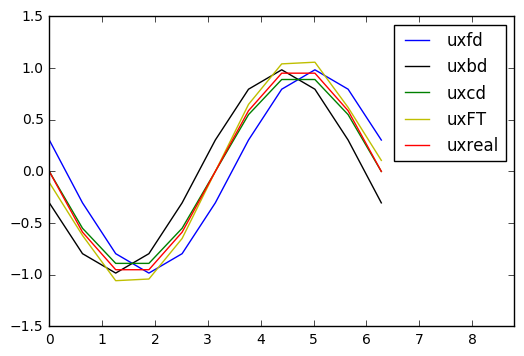

In [179]:
# Let's compute the derivatives for u(x) = cos(x) which we know to be u(x) = -sin(x)

nx = 11                # number of points in x, Nadia, vary this to see how accurate we can get to the real solution
L = 2.*np.pi           # the period 
x0 = 0.0               # beginning endpoint
xn = L                 # end endpoint
x = np.linspace(x0, xn, nx) # declaring the space
dx = x[1]-x[0]         # size of the step in x

u = np.cos(x)          # defining the known function u(x)
#plt.plot(x,u,'g')      # plotting

# declaring the variable that will hold the derivative
uxfd = np.zeros(nx)      
uxbd = np.zeros(nx)      
uxcd = np.zeros(nx)      
uxFT = np.zeros(nx)
uxreal = -np.sin(x)

## main loop for generating the derivatives using differences, but what happens at endpoints?
print range(nx)
print np.shape(uxfd)

# using the forward differences - method in the tutorial from before
for n in range(nx-1):  # looping from 0 to nx-2 using n
    uxfd[n+1] = 1./(dx)*(u[n+1]-u[n])           # this assigns values from element 1 to nx-1 in ux 
# taking care of the 0th element, assuming periodic boundary conditions:
# this means u[0] = u[nx-1] = u[-1] (the element on the right boundary is the same as the element on the left boundary
# therefore, u[1] = u[nx] (outside of the boundary) = u[-2] and etc.
# could put this into the main loop, but how? 
uxfd[0] = 1./(dx)*(u[0]-u[-2]) #<- comment this line to see what happens to the left point otherwise!
    
# using the backward differences - method 1    
for n in range(nx-1):  # looping from 0 to nx-2 using n
    uxbd[n] = 1./(dx)*(u[n+1]-u[n])             # this assigns values from element 0 to nx-2 in ux
# taking care of the nx-1 element, assuming periodic boundary conditions:
# this means u[0] = u[nx-1] = u[-1] (the element on the right boundary is the same as the element on the left boundary
# therefore, u[1] = u[nx] (outside of the boundary) = u[-2] and etc.
# could put this into the main loop, but how?
uxbd[nx-1] = 1./(dx)*(u[1]-u[nx-1]) #<- comment this line to see what happens to the right point otherwise!
    
# using the centred differences - method 2
for n in range(nx-2):  # looping from 0 to nx-3 using n
    uxcd[n+1] = 1./(2.*dx)*(u[n+2]-u[n])        # this assigns values from element 1 to nx-2 in ux
#Q1: what happens for 0th and nx-1 element!? <- Nadia, can you take care of the periodic BCs?


# method 3 with Fourier transform is simply
uxFT = psdiff(u, period=L)

plt.plot(x,uxfd,'b')           # plotting the result from forward differencing scheme
plt.plot(x,uxbd,'k')           # plotting the result from backward differencing scheme
plt.plot(x,uxcd,'g')           # plotting the result from centred differencing scheme
plt.plot(x,uxFT,'y')           # plotting the result from centred differencing scheme
plt.plot(x,uxreal,'r')         # plotting the real ux

plt.xlim(0,8.8)
plt.legend(['uxfd', 'uxbd', 'uxcd', 'uxFT', 'uxreal'])

# we can even measure the maximum error for each scheme
errfd = np.max(np.abs(uxfd-uxreal))
print "The error for the forward difference is " + str(errfd)
errbd = np.max(np.abs(uxbd-uxreal))
print "The error for the backward difference is " + str(errbd)
errcd = np.max(np.abs(uxcd-uxreal))
print "The error for the centred difference is " + str(errcd)
errFT = np.max(np.abs(uxFT-uxreal))
print "The error for the Fourier transform is " + str(errFT)



Now that we played around with different schemes, we can move on to solving differential equations 
### 1D Linear Convection
We are interested in solving

 $$ \frac{\partial u}{\partial t} = - c \frac{\partial u}{ \partial x} $$

using a variety of methods including different difference schemes as well as Fourier transforms.

We can proceed as in the previous notebook and disretize the derivatives so that we obtain

 $$ u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n) $$
 
where we have used a **forward differencing scheme in time** and a **backward scheme in space**. 

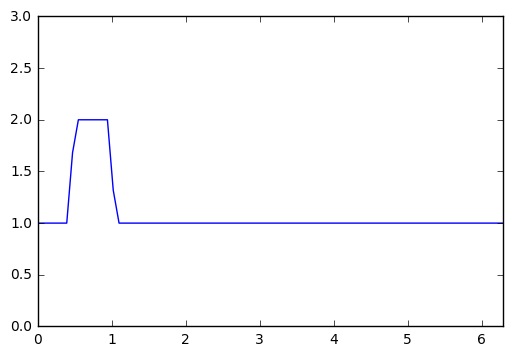

In [315]:
################################# code copied from Tutorial 1 ############################

nx = 81  # try changing this number from 41 to 81 and Run All ... what happens?
xn = 2.*np.pi
dx = xn/(nx-1)
nt = 201    #nt is the number of timesteps we want to calculate
dt = .025  #dt is the amount of time each timestep covers (delta t)
c = 1      #assume wavespeed of c = 1
x = np.linspace(0, xn, nx)


u = np.ones(nx)      #numpy function ones()
u[int(.5 / dx):int(1 / dx + 1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s
un = np.ones(nx) #initialize a temporary array
unTot = np.zeros((nx,nt)) # modification by Olga to add a storage variable

for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
    un = u.copy() ##copy the existing values of u into un
    for i in range(1, nx): ## you can try commenting this line and...
    #for i in range(nx): ## ... uncommenting this line and see what happens!
        u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
        
    unTot[:,n] = u # modification by Olga <- storing the solution for all times
    
##########################################################################################


# Olga's addition of a plotting function

def pltsoln(ntime):
    plt.plot(x,unTot[:,ntime])
    plt.ylim(0.0, 3.0)
    plt.xlim(0.0, xn)
    plt.show()
    
widgets.interact(pltsoln, ntime=(0, nt-1, 1)) # using a widget to plot, the loop is over integer values


Now we will modify the above function to solve the linear convection using the centered differences in space (why is this?)
 
$$ u_i^{n+1} = u_i^n - c \frac{\Delta t}{2 \Delta x}(u_{i+1}^n-u_{i-1}^n) $$

What's going on here?

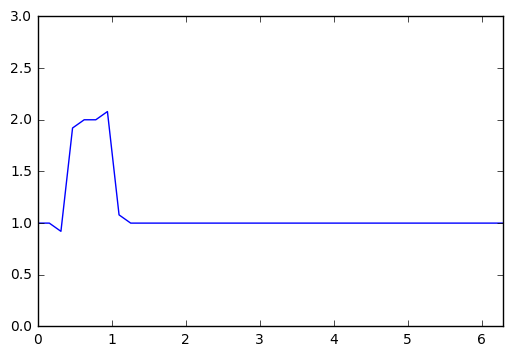

In [333]:
nx = 41  
xn = 2.*np.pi
dx = xn/(nx-1)
nt = 201    
dt = .025  
c = 1      
x = np.linspace(0, xn, nx)

# initial condition that looks like a step
u = np.ones(nx)      
u[int(.5 / dx):int(1 / dx + 1)] = 2.0  #setting u = 2 between 0.5 and 1 as per our I.C.s
un = np.zeros(nx) #initialize a temporary array

unTot = np.zeros((nx,nt)) 

 
for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
    un = u.copy() # copy the existing values of u into un
    
    for i in range(nx-1): 
        u[i] = un[i] - c*dt/(2.*dx) * (un[i+1] - un[i-1])        # this assigns values from element 1 to nx-2 in ux
        
    unTot[:,n] = u # modification by Olga <- storing the solution for all times
    
#########################################################################
def pltsoln(ntime):
    plt.plot(x,unTot[:,ntime])
    plt.ylim(0.0, 3.0)
    plt.xlim(0.0, xn)
    plt.show()
    
widgets.interact(pltsoln, ntime=(0, nt-1, 1)) # using a widget to plot, the loop is over integer values


We have computed the solution to the linear convection equation in two different ways. Now we will try with a different intial condition and periodic boundary conditions, making use of the Fourier Transform and compare two different schemes for doing the integration in time (check out  [Linear Multistep Methods article on Wikipedia](https://en.wikipedia.org/wiki/Linear_multistep_method)) 
1. Euler Method from before
2. Adams–Bashforth 2 step method 

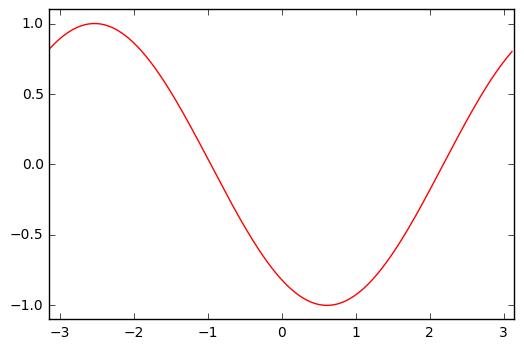

In [309]:
nx = 201              # number of points in x, Nadia, vary this to see how accurate we can get to the real solution
L = 2.*np.pi           # the period 
x0 = -L/2.             # beginning endpoint
xn = L/2.                 # end endpoint
dx = x[1]-x[0]         # size of the step in x
x = np.linspace(x0, xn-dx, nx) # declaring the space

nt = 1501   # nt is the number of timesteps we want to calculate
dt = .0025  # dt is the amount of time each timestep covers (delta t)
c = 1.0      # assume wavespeed of c = 1


############################# Euler Method ###############################

# initial condition that looks like a cosine, this will be periodic of period 2*pi
u = np.cos(x)

# derivative using FT
ux = -np.sin(x)
unx = psdiff(u)

#initialize a temporary array
un = np.zeros(nx)
unTot = np.zeros((nx,nt)) 

for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
    un = u.copy()   # storing the solution from 1 step back
    
    # compute the derivative via a Fourier transform.
    unx = psdiff(un)
        
    for i in range(nx):         
        u[i] = un[i] - c*dt*unx[i]      # Nadia, what happens when you change the - to a + sign
        
        
    unTot[:,n] = u

########################### A-B 2 step method #############################

# initial condition that looks like a cosine, this will be periodic of period 2*pi
u = np.cos(x)

# derivative using FT
ux = -np.sin(x)
unx = psdiff(u)

#initialize a temporary array
un1 = np.zeros(nx)
un2 = np.zeros(nx)
un2Tot = np.zeros((nx,nt)) 

for n in range(nt):  
    un2 = un1.copy() # storing the solution from 2 steps back
    un1 = u.copy()   # storing the solution from 1 step back
    
    # compute the derivative via a Fourier transform.
    un2x = psdiff(un2)
    un1x = psdiff(un1)
        
    if n == 0:
        for i in range(nx):         
            u[i] = un1[i] - c*dt*un1x[i]
            
    else:
        for i in range(nx):         
            u[i] = un1[i] - c*dt*(3./2.*un1x[i] - 1./2.*un2x[i])
        
        
    un2Tot[:,n] = u
    
#########################################################################

def pltsoln(ntime):
    plt.plot(x,unTot[:,ntime])
    plt.ylim(-1.1, 1.1)
    plt.xlim(x0, xn)
    plt.show()
    
def pltsoln2(ntime):
    plt.plot(x,un2Tot[:,ntime],'r')
    plt.ylim(-1.1, 1.1)
    plt.xlim(x0, xn)
    plt.show()
    
widgets.interact(pltsoln, ntime=(0, nt-1, 1)) # using a widget to plot, the loop is over integer values

widgets.interact(pltsoln2, ntime=(0, nt-1, 1)) # using a widget to plot, the loop is over integer values

### Question for Nadia, can you use the highest order method we have seen to solve the linear KdV which is
$$ \frac{\partial u}{\partial t} = -  \frac{\partial^3 u}{\partial t^3} $$
what has to change in the code above?